# Static preprocessing implementations

Getting some sample data we can test the classes on

In [1]:
%cd ..

/data/mas322/amex-project


In [14]:
import yaml
import os
import importlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn

from src.lib import experimentation
from src.models import basic_grunet
import src.experiments.static_preprocessing_methods.experiment_setup as spm

with open(os.path.join("config.yaml")) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

# Note this should follow the interface of sklearn BaseEstimator using a fit, transform and fit_transform function
class IdentityTransform(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        # https://docs.cupy.dev/en/stable/user_guide/interoperability.html#pytorch
        # consider using cupy if too slow with base numpy ^^
        return self
    
    def transform(self, X):
        return X

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : True,
    'drop_last' : True,
}

fill_dict = {
    'nan' : -0.5,
    'pad_categorical' : -2,
    'pad_numeric' : -1.,
}

np.random.seed(42)
torch.manual_seed(42)

# load corrupted data
train_loader, val_loader = experimentation.load_numpy_data(
    os.path.join(cfg['dataset_directory'], "derived", "processed-splits"),
    val_idx=[0, 1],
    fill_dict=fill_dict,
    preprocess_obj=IdentityTransform(),
    corrupt_func=spm.undo_min_max_corrupt_func,
    **data_loader_kwargs)

for X, y in train_loader:
    break
X, y = X.numpy()[:, :, 11:], y.numpy()[11:]
print(f"X shape: {X.shape}")

# also load uncorrupted data for sanity checking
train_loader, val_loader = experimentation.load_numpy_data(
    os.path.join(cfg['dataset_directory'], "derived", "processed-splits"),
    val_idx=[0, 1],
    fill_dict=fill_dict,
    preprocess_obj=IdentityTransform(),
    corrupt_func=None,
    **data_loader_kwargs)
for X_uncorrupted, _ in train_loader:
    break
X_uncorrupted = X_uncorrupted.numpy()[:, :, 11:]

X shape: (1024, 13, 177)


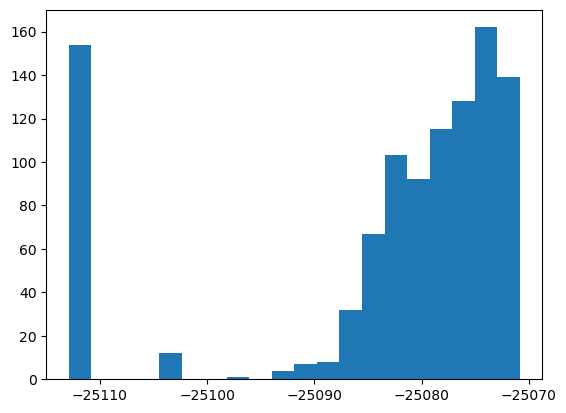

In [15]:
import matplotlib.pyplot as plt

plt.hist(X[:, 0, 0], bins = 20)
plt.show()

## Standard scaling

In [16]:
torch.zeros((5,)).is_cuda

False

In [17]:
# TODO

## Decimal scaling

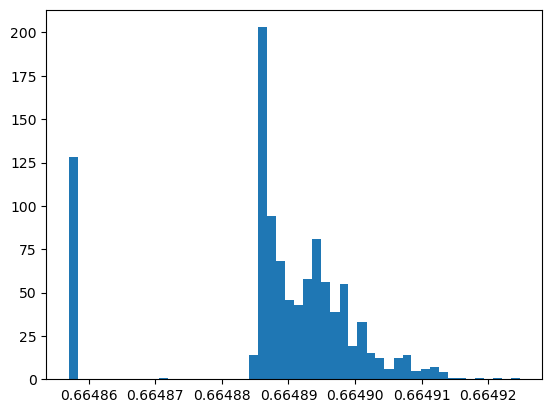

In [26]:
class DecimalScaling(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, time_series_length=13):
        self.T = time_series_length
        pass
    
    def fit(self, X, y = None):
        # merge the dimensions and time axis
        X = X.reshape((X.shape[0], -1))
        max_vals = np.max(np.abs(X), axis=0)
        # the exponent (base 10) that each feature should be scaled with
        q = np.array(np.log10(max_vals) + 1, dtype=np.int16)
        self.scale_factor = 1 / np.power(10., q, dtype=np.float32)
        return self
    
    def transform(self, X):
        X = X.reshape((X.shape[0], -1))
        # scale all the features
        X = X * self.scale_factor
        return X.reshape((X.shape[0], self.T, -1))

ds = DecimalScaling()
X_new = ds.fit_transform(X, y)
plt.hist(X_new[:, 1, 12], bins=50)
plt.show()

## Min-Max scaling

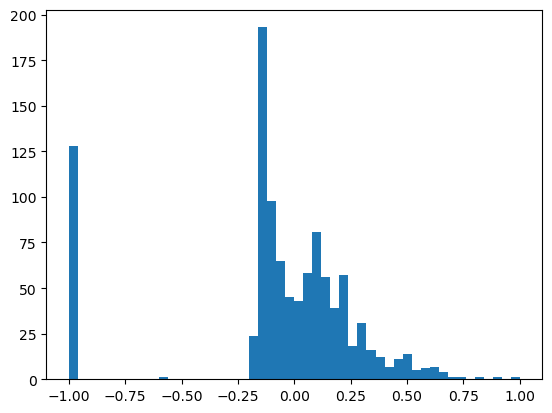

In [49]:
from sklearn import preprocessing

class MinMaxTimeSeries(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, a=0, b=1, time_series_length=13):
        self.T = time_series_length
        self.min_max_scaler = preprocessing.MinMaxScaler(feature_range=(a, b))
        pass
    
    def fit(self, X, y = None):
        # merge the dimensions and time axis
        X = X.reshape((X.shape[0], -1))
        self.min_max_scaler.fit(X, y)
        return self
    
    def transform(self, X):
        X = X.reshape((X.shape[0], -1))
        # scale all the features
        X = self.min_max_scaler.transform(X)
        return X.reshape((X.shape[0], self.T, -1))

min_max = MinMaxTimeSeries(-1, 1)
X_new = min_max.fit_transform(X, y)
plt.hist(X_new[:, 1, 12], bins=50)
plt.show()

## Analysing results

In [ ]:
no_preprocess = np.load(os.path.join(cfg['experiment_directory'], 'no-preprocess-history.npy'), allow_pickle=True).item()
no_preprocess.keys()

dict_keys(['train_loss', 'val_loss', 'train_amex_metric', 'val_amex_metric', 'train_loss_mean', 'train_loss_sd', 'val_loss_mean', 'val_loss_sd', 'train_amex_metric_mean', 'train_amex_metric_sd', 'val_amex_metric_mean', 'val_amex_metric_sd', 'num_epochs'])

In [54]:
def plot_cv(history, suffix, ax, **kwargs):
    train_mean = []
    val_mean = []
    epoch = 0
    while True:
        avg_train_val = 0.
        avg_val_val = 0.
        num_vals = 0
        for i in range(5):
            if len(history[f"train_{suffix}"][i]) > epoch:
                num_vals += 1
                avg_train_val += history[f"train_{suffix}"][i][epoch]
                avg_val_val += history[f"val_{suffix}"][i][epoch]
        if num_vals == 0:
            break
        train_mean.append(avg_train_val / num_vals)
        val_mean.append(avg_val_val / num_vals)
        epoch += 1
    
    for i in range(5):
        ax.plot(history[f"train_{suffix}"][i], alpha = 0.5,
                label = "Train" if i == 0 else None,
                color = 'tab:blue',
                linestyle = 'dashed', **kwargs)
        ax.plot(history[f"val_{suffix}"][i], alpha = 0.5,
                label = "Val" if i == 0 else None,
                color = 'tab:orange',
                linestyle = 'dashed', **kwargs)
    
    ax.plot(train_mean, label="Train (CV mean)", **kwargs)
    ax.plot(val_mean, label="Val (CV mean)", **kwargs)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(suffix)
    ax.legend()

Text(0.5, 1.0, 'Amex metric')

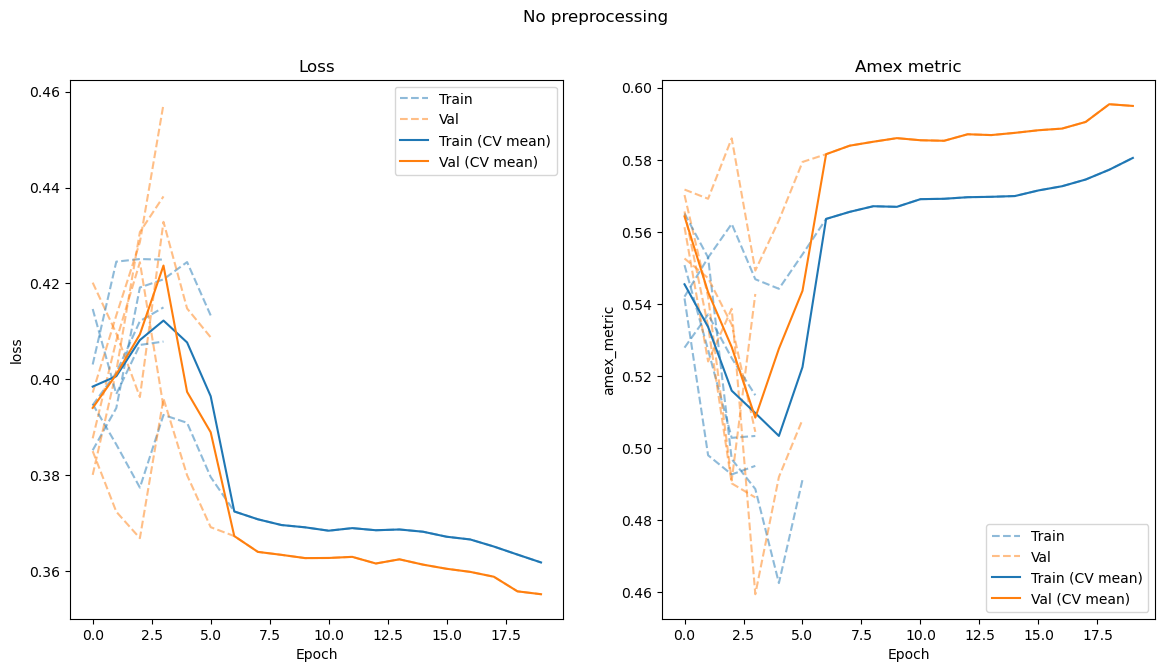

In [55]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
fig.suptitle("No preprocessing")
plot_cv(no_preprocess, "loss", axs[0])
axs[0].set_title("Loss")
plot_cv(no_preprocess, "amex_metric", axs[1])
axs[1].set_title("Amex metric")

dict_keys(['train_loss', 'val_loss', 'train_amex_metric', 'val_amex_metric', 'train_loss_mean', 'train_loss_sd', 'val_loss_mean', 'val_loss_sd', 'train_amex_metric_mean', 'train_amex_metric_sd', 'val_amex_metric_mean', 'val_amex_metric_sd', 'num_epochs'])


Text(0.5, 1.0, 'Amex metric')

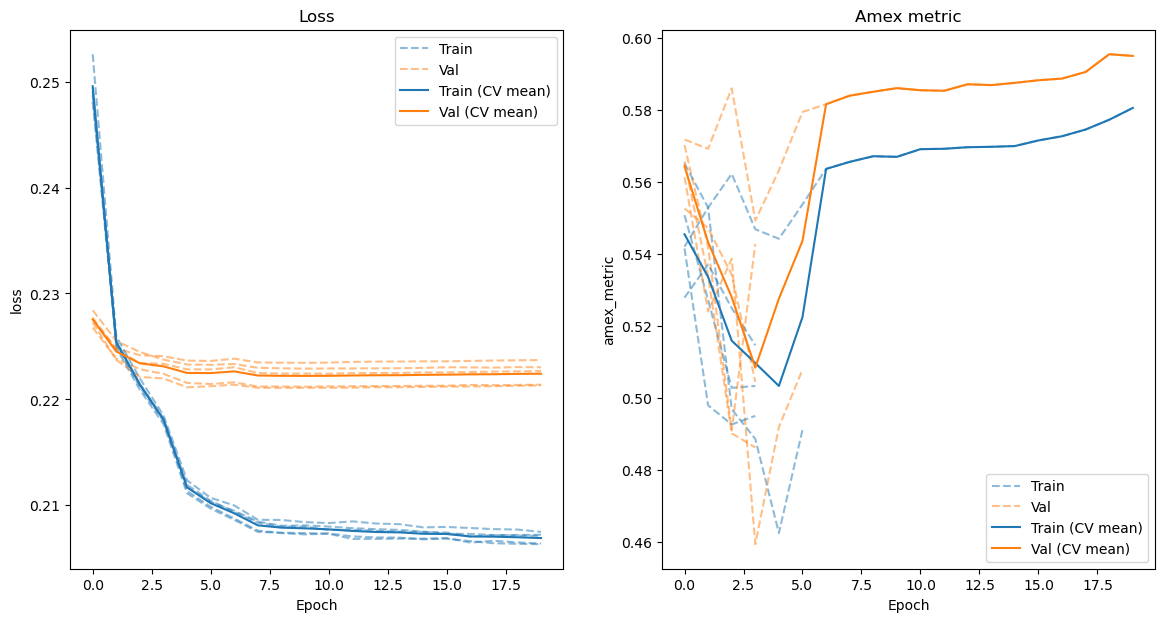

In [56]:
standard_scaling = np.load(os.path.join(cfg['experiment_directory'], 'standard-scaling-history.npy'), allow_pickle=True).item()
print(standard_scaling.keys())
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
plot_cv(standard_scaling, "loss", axs[0])
axs[0].set_title("Loss")
plot_cv(no_preprocess, "amex_metric", axs[1])
axs[1].set_title("Amex metric")